# Ciclope voxel uFE pipeline @ JCW_2022
From a CT image of trabecular bone to voxel-uFE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 10.06.2022 <br />

- Data source: LHDL project (IOR Bologna, Italy)
- More info on the dataset source [here](http://projects.kmi.open.ac.uk/lhdl/)
- For info on the solver visit the [Calculix homepage](http://www.calculix.de/)

---
The pipeline can be executed from the command line using the **ciclope** command: <br />
```commandline
python ciclope.py test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif test_data/LHDL/3155_D_4_bc/3155_D_4_bc.inp -vs 0.0195 0.0195 0.0195 -r 2 -t 63 --voxelfe --template input_templates/tmp_example01_comp_static_bone.inp
```

Type `python ciclope.py -h` to display the ciclope help with detailed information on command line arguments.


![](./../test_data/steel_foam/IMG_20201121_225702.jpg)

## Configuration

In [3]:
import sys
sys.path.append('./../../')

In [4]:
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
import ciclope

In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

#### Load input data

In [6]:
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Energy| |
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [7]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

Inspect the dataset

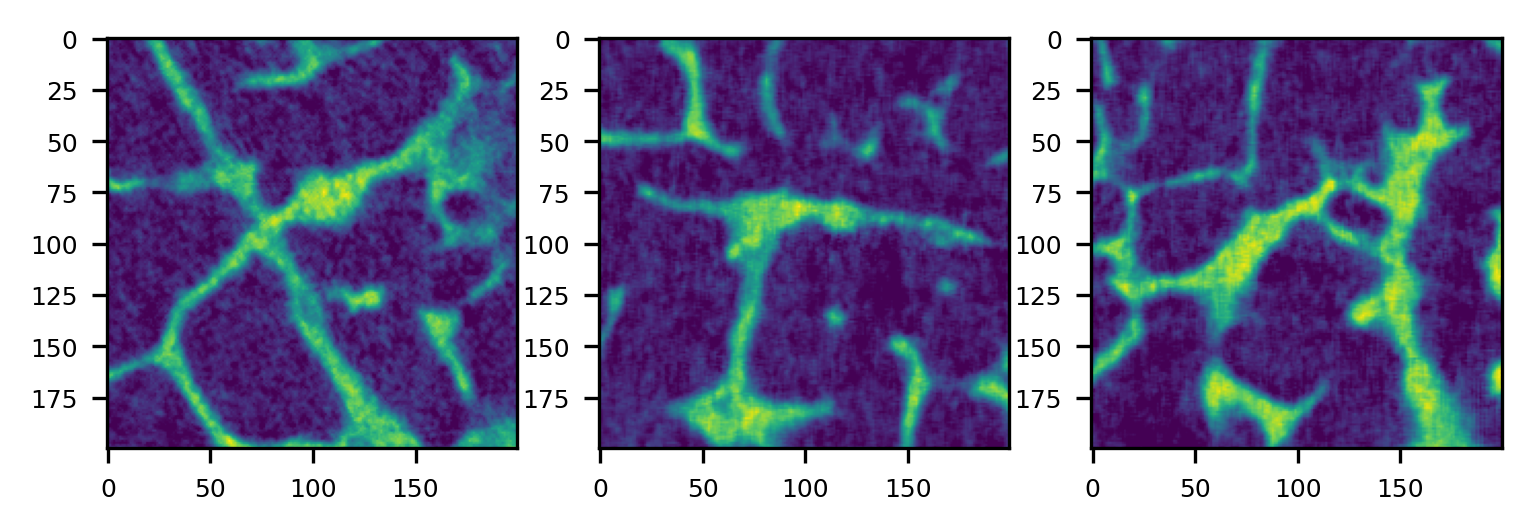

In [8]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [12]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [14]:
# launch itk viewer
viewer

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

## Pre-processing
### Gaussian smooth

In [15]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (downsample) with factor 2

In [16]:
resampling = 2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

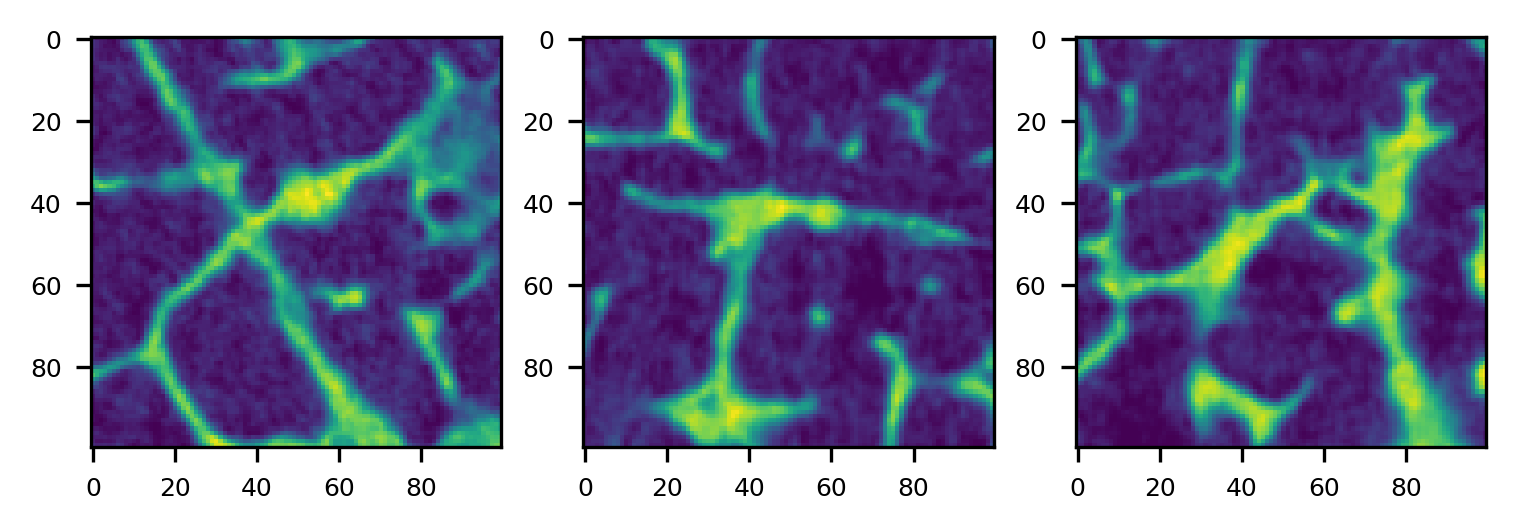

In [17]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding


In [18]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.72472439570987


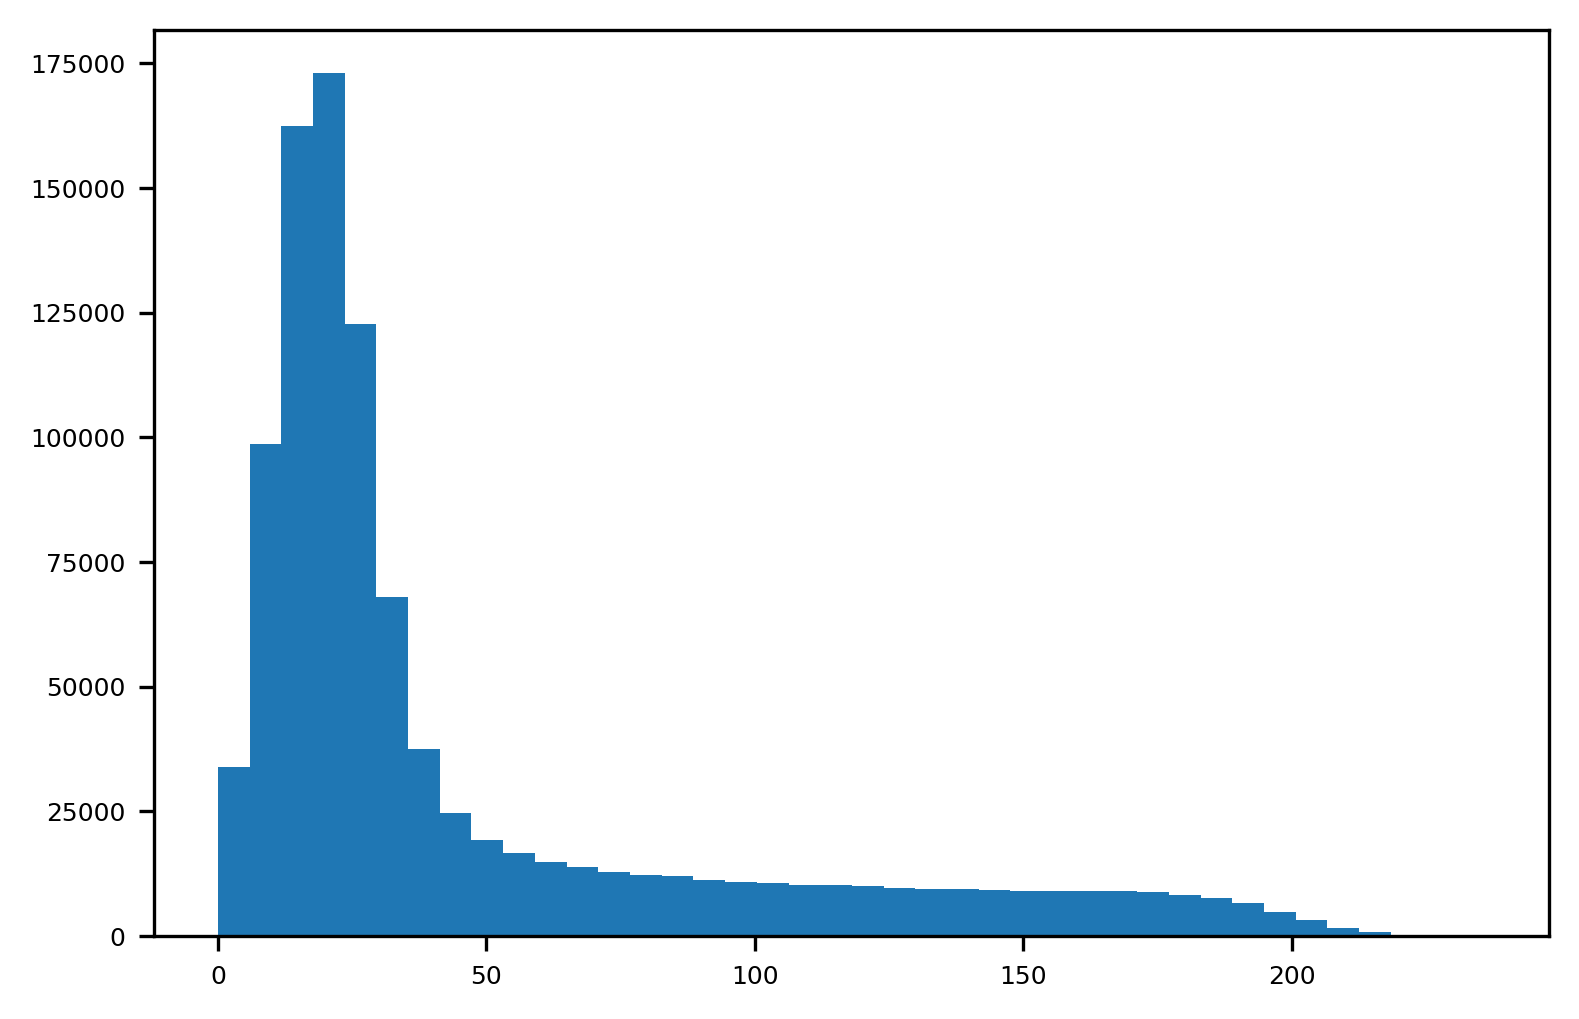

In [19]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply the threshold

In [20]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

Have a look at the binarized dataset

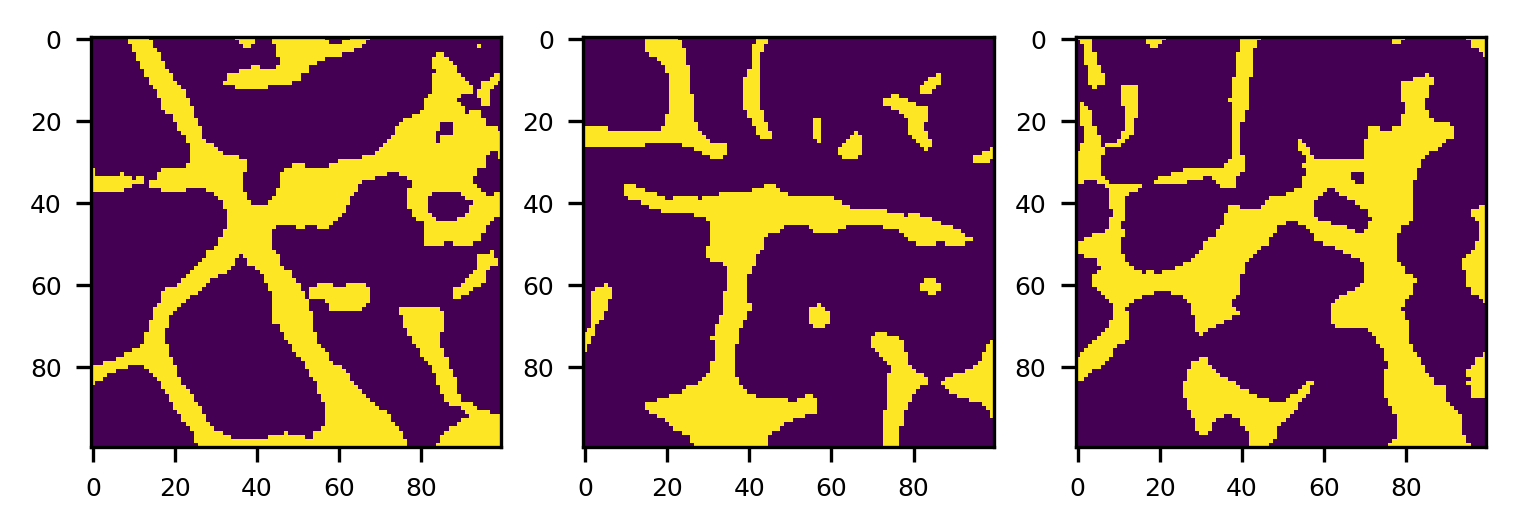

In [21]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [22]:
BW = morphology.closing(BW, morphology.ball(3))

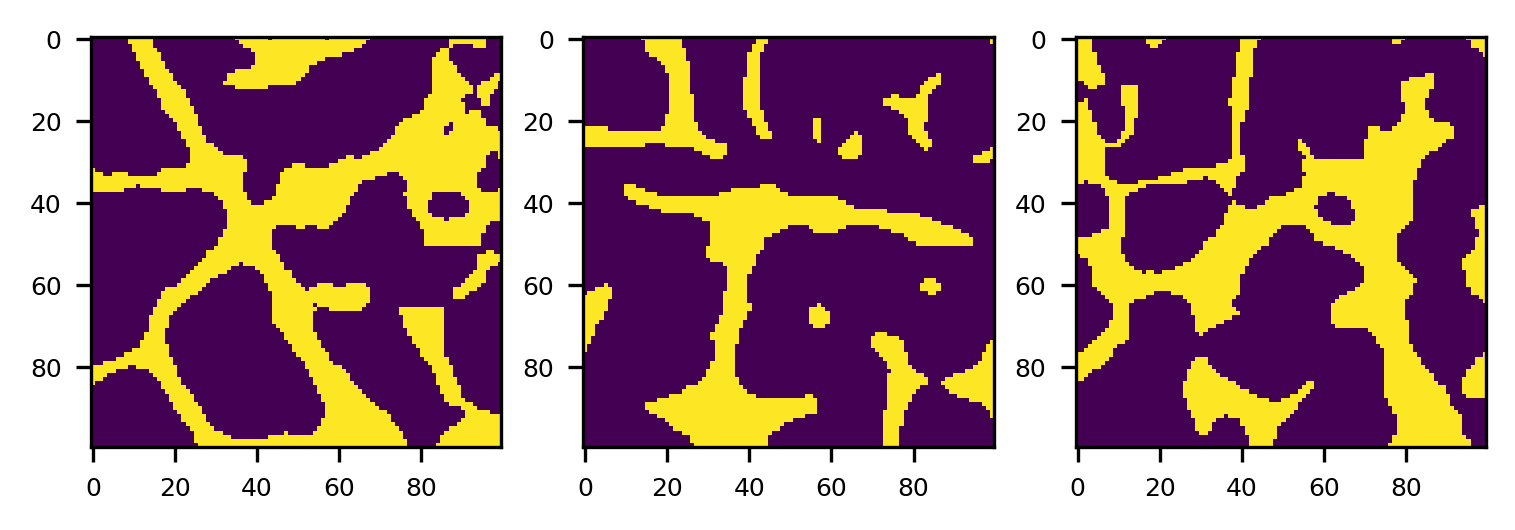

In [23]:
plot_midplanes(BW)
plt.show()

### Crop a small portion (for checking)

In [38]:
# BW = BW[50:100 ,50:100, 50:100]

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [ ]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [ ]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [ ]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in the ciclope module **pybonemorph**

In [24]:
from pybonemorph import remove_unconnected

In [25]:
L = remove_unconnected(BW)

Inspect dataset

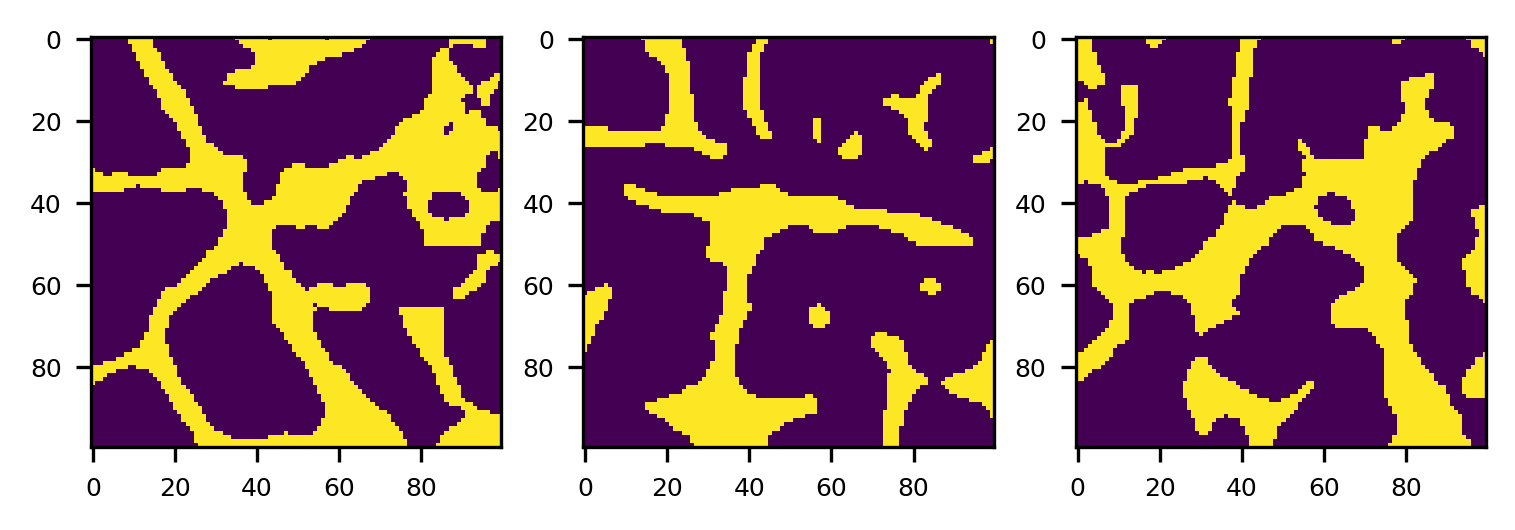

In [26]:
plot_midplanes(L)
plt.show()

## Generate Unstructired Grid Mesh of hexahedra from volume data

In [27]:
mesh = ciclope.voxelFE.vol2ugrid(L, vs, verbose=True)

INFO:root:Calculating cell array
INFO:root:Detecting node coordinates and boundary nodes
INFO:root:Generated the following mesh with 1030301 nodes and 247062 elements:
INFO:root:<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 247062
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


Write the mesh for checking using `meshio`

In [18]:
# filename_mesh_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelmesh.vtk'
# mesh.write(filename_mesh_out)

## Write CalculiX input FE files
### Generate voxel-FE model with constant material properties
If a binary ndarray is given as input, the script `vol2voxelfe` will assume that the material property definition is contained in the FE analysis `.INP` template file.

https://classes.engineering.wustl.edu/2009/spring/mase5513/abaqus/docs/v6.6/books/usb/default.htm?startat=pt05ch17s02abm02.html

In [32]:
filename_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE.inp'

In [33]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone.inp"

In [34]:
!cat {input_template}

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S
*END STEP


In [35]:
ciclope.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, verbose=True)

INFO:root:Found cell_data: GV. cell_data range: True - True.
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:Reading Abaqus template file ./../../input_templates/tmp_example01_comp_static_bone.inp
INFO:root:Model with 1030301 nodes and 247062 elements written to file ./../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [36]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:      1030249
   elements:       247062
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            8
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:        11787
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [37]:
import os
import ccx2paraview

In [38]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading 3155_D_4_bc_voxelFE.frd
INFO:root:336277 nodes
INFO:root:247062 cells
INFO:root:Step 1, time 1.0, U, 3 components, 336277 values
INFO:root:Step 1, time 1.0, S, 6 components, 336277 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 336277 values
INFO:root:1 time increment
INFO:root:Writing 3155_D_4_bc_voxelFE.vtk


INFO:root:Step 1, time 1.0, U, 3 components, 336277 values
INFO:root:Step 1, time 1.0, S, 6 components, 336277 values
INFO:root:Step 1, time 1.0, S_Mises, 1 components, 336277 values
INFO:root:Step 1, time 1.0, S_Principal, 3 components, 336277 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 336277 values


### Reaction forces

In [39]:
!cat {filename_out_base+'.dat'}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

       -1.692646E-11  7.263495E-13  2.473045E+02


### Apparent elastic modulus

In [60]:
E = 2.47e2/0.04
print(f"{E:.2f}MPa")

6175.00MPa


Bone volume fraction

In [58]:
BVTV = 100*np.sum(L)/L.size
print(f"{BVTV:.2f}%")

24.71%


#### Visualize results in Paraview

In [ ]:
!paraview filename_out_base + '.vtk'

![](./../test_data/trabecular_bone/U3.png)

Visuailzation with itkwidgtes (does not show field data..)

In [ ]:
import vtk

In [ ]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_vtk)
reader.Update()
grid = reader.GetOutput()

In [ ]:
view(geometries=grid)

---
## Heterogeneous material mapping
Description here

#### Mask the dataset

In [69]:
masked = data_3D.copy()

In [72]:
masked[~L] = 0

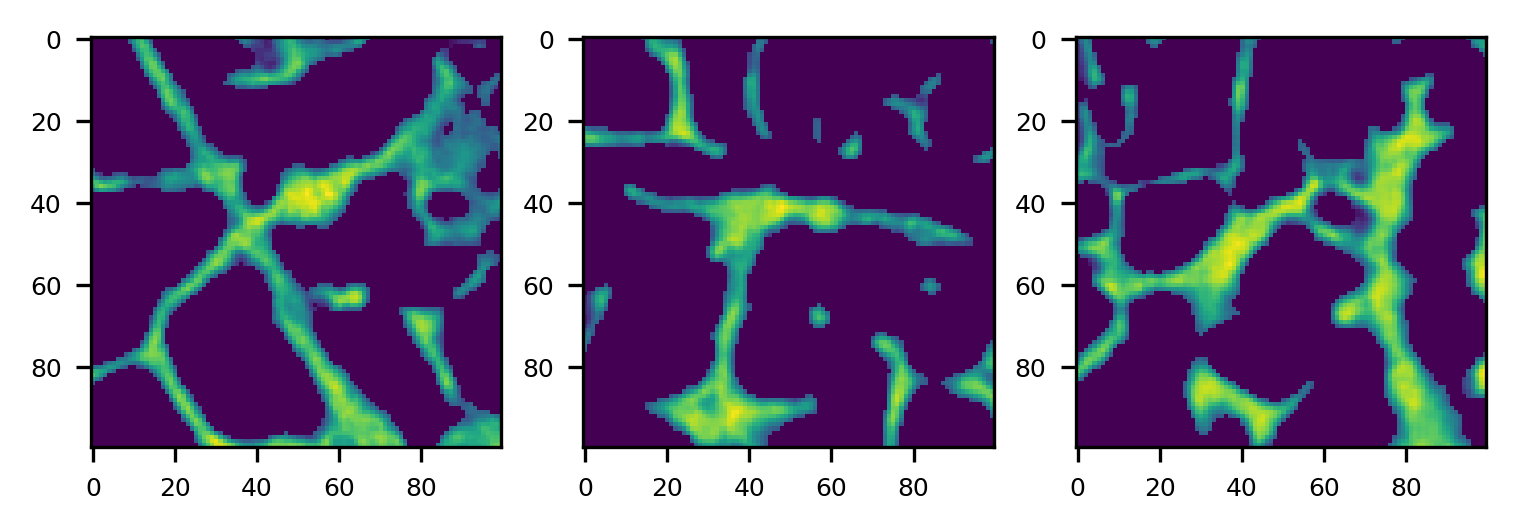

In [74]:
plot_midplanes(masked)

## Generate Unstructired Grid Mesh of hexahedra from volume data

In [81]:
masked.astype('uint8')

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 30,  46,  73, ...,  51,  89, 112],
        [ 30,  47,  72, ...,  64, 100, 113],
        [ 42,  61,  81, ...,  60,  82,  86]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 52,  62,  86, ...,  59,  99, 120],
        [ 68,  77,  92, ...,  87, 123, 135],
        [ 88,  99, 108, ...,  93, 111, 107]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 74,  66,  67, ...,  90, 127, 138],
        [103,  90,  78, ..., 125, 147, 145],
        [128, 117, 102, ..., 130, 131, 113]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0

In [80]:
mesh = ciclope.voxelFE.vol2ugrid(masked, vs, verbose=True)

TypeError: only size-1 arrays can be converted to Python scalars

In [78]:
print(mesh.cell_data)

{'GV': [array([ 14.59207886,  19.51279427,  24.93120234, ..., 186.58359238,
       149.12178316,  96.41506316])]}


Write the mesh for checking using `meshio`

In [18]:
# filename_mesh_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelmesh.vtk'
# mesh.write(filename_mesh_out)

## Write CalculiX input FE files
### Generate voxel-FE model with constant material properties
If a binary ndarray is given as input, the script `vol2voxelfe` will assume that the material property definition is contained in the FE analysis `.INP` template file.

https://classes.engineering.wustl.edu/2009/spring/mase5513/abaqus/docs/v6.6/books/usb/default.htm?startat=pt05ch17s02abm02.html

In [32]:
filename_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE.inp'

In [33]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone.inp"

In [34]:
!cat {input_template}

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S
*END STEP


In [35]:
ciclope.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, verbose=True)

INFO:root:Found cell_data: GV. cell_data range: True - True.
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:Reading Abaqus template file ./../../input_templates/tmp_example01_comp_static_bone.inp
INFO:root:Model with 1030301 nodes and 247062 elements written to file ./../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_voxelFE.inp
